In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from efn_util import drawEtas
from scipy.stats import multivariate_normal
from plot_utils import plotContourNormal, Dirichlet, draw_pdf_contours, plotContourTruncatedNormal
import seaborn as sns
import tensorflow as tf
import time

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

exp_fam = 'dir_dir';
D = 3;
flow_id = '10P';
rs = 0;

In [2]:
savedir = '/Users/sbittner/Documents/efn/results/MK/tb/NF1_%s_D=%d_flow=%s_rs=%d/' \
          % (exp_fam, D, flow_id, rs);

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
sess = tf.Session();
new_saver = tf.train.import_meta_graph(savedir + 'model.meta');
new_saver.restore(sess, tf.train.latest_checkpoint(savedir));
Z0 = tf.get_collection('Z0')[0];
X = tf.get_collection('X')[0];
eta = tf.get_collection('eta')[0];
log_p_zs = tf.get_collection('log_p_zs')[0];
Tx_input = tf.get_collection('Tx_input')[0];

INFO:tensorflow:Restoring parameters from /Users/sbittner/Documents/efn/results/MK/tb/NF1_dir_dir_D=3_flow=10P_rs=0/model


(1, 9)


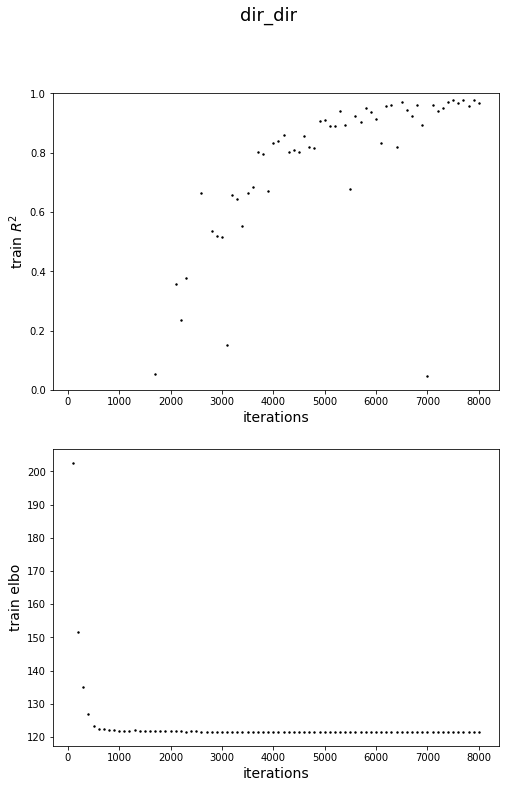

In [3]:
fontsize = 14;
size = 2;

fname = savedir + 'results.npz';
npzfile = np.load(fname);
params = npzfile['params'][()];
_eta = npzfile['eta'];
_Tx_input = npzfile['Tx_input'];
print(_eta.shape);
_X = npzfile['X'];
train_elbos = npzfile['train_elbos'];
train_R2s = npzfile['train_R2s'];

check_rate = 100;
N = train_elbos.shape[0];
K_eta = train_R2s.shape[1];
its = check_rate*np.arange(1,N+1, dtype=float);
its = np.tile(np.expand_dims(its, 1), [1,K_eta]);
its_vec = np.reshape(its, (N*K_eta,));
train_elbos_vec = np.reshape(train_elbos[:N,:], (N*K_eta,));
train_R2s_vec = np.reshape(train_R2s[:N,:], (N*K_eta,));

fig = plt.figure(figsize=(8,12));
fig.add_subplot(2,1,1);
plt.scatter(its_vec, train_R2s_vec,size,c='k');
plt.xlabel('iterations', fontsize=fontsize);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train $R^2$', fontsize=fontsize)
plt.ylim([0,1]);
plt.suptitle(exp_fam, fontsize=fontsize+4)

fig.add_subplot(2,1,2);
plt.scatter(its_vec, train_elbos_vec,size,c='k');
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train elbo', fontsize=fontsize)


In [4]:
print(X);
print(Z0);
print(eta);
print(log_p_zs);

Tensor("concat:0", shape=(?, ?, 3, ?), dtype=float64)
Tensor("Placeholder:0", shape=(?, ?, 2, 1), dtype=float64)
Tensor("Placeholder_1:0", shape=(?, 9), dtype=float64)
Tensor("sub_22:0", shape=(?, ?), dtype=float64)


In [5]:
from plot_utils import Dirichlet, draw_pdf_contours, bc2xy, xy2bc
from scipy.stats import dirichlet
import matplotlib.tri as tri
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
from efn_util import dir_dir_eta

def get_dist_trimesh_probs(dist, trimesh):
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    return pvals;

def draw_pdf_contours(dist, trimesh, contour_levels, show_logp, **kwargs):
    import math
    mycm = sns.light_palette("navy", as_cmap=True)
    mycm.set_under('w')
    pvals = get_dist_trimesh_probs(dist, trimesh);
    if (show_logp):
        vals = np.log(pvals);
    else:
        vals = pvals;
    plt.tricontourf(trimesh, vals, contour_levels, cmap=mycm)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
def closest(support_point, Xgrid):
    #constructs an nxn grid and gives back the point on the grid which, after being transformed by the network
    #is closest to simplex_point
    diffs = Xgrid - np.expand_dims(support_point, 0);
    dists = np.linalg.norm(diffs, ord=2, axis=1);
    clos_ind = np.argmin(dists);
    return clos_ind;

def plotDirichletPosterior(Xgrid, log_p_z_grid, contour_levels, show_logp):
    sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.6))
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
    sbpal = sns.color_palette()
    
    n_plot = len(trimesh.x);
    log_p_trimesh = np.zeros((n_plot,));
    start_time = time.time();
    for i in range(n_plot):
        support_point = np.array([trimesh.x[i], trimesh.y[i]]);
        ind = closest(xy2bc(support_point), Xgrid);
        log_p_z_ij = log_p_z_grid[ind];
        log_p_trimesh[i] = log_p_z_ij;
    end_time = time.time();
    #print('finding closest grid probs took %.2fs' % (end_time - start_time));

    mycm = sns.light_palette("navy", as_cmap=True)
    mycm.set_under('w')
    start_time = time.time();
    if (show_logp):
        vals = log_p_trimesh;
    else:
        p_trimesh = np.exp(log_p_trimesh);
        vals = p_trimesh;
    plt.tricontourf(trimesh, vals, contour_levels, cmap=mycm)
    end_time = time.time();
    #print('drawing contour took %.2fs' % (end_time - start_time));
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    return trimesh, log_p_trimesh;

def gen_grid(sess, n, X, Z0, log_p_zs, eta, _eta, Tx_input, _Tx_input):
    K = _eta.shape[0];
    M = n*n;
    x = np.linspace(-3.5,3.5,n)
    _z0 = np.zeros((M,2));
    for i in range(n):
        for j in range(n):
            ind = n*i+j;
            _z0[ind,0] = x[i];
            _z0[ind,1] = x[j];
    z0 = np.expand_dims(np.expand_dims(_z0, 0), 3);
    feed_dict = {Z0:z0, eta:_eta, Tx_input:_Tx_input};
    Xgrid, log_p_z_grid = sess.run([X, log_p_zs], feed_dict);

    return Xgrid, log_p_z_grid, _z0;

betas [1.]
zs [[0.98 0.01 0.01]]


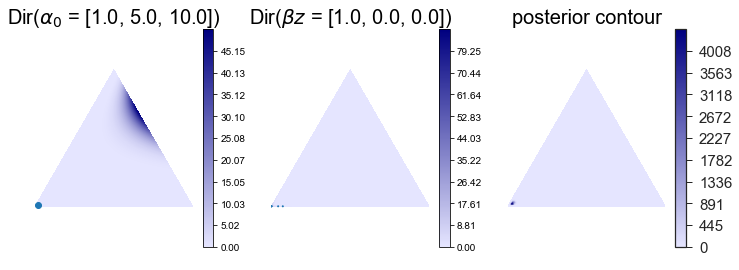

In [6]:
fontsize = 20;
alpha_0s = params['alpha_0s'];
betas = params['betas'];
xs = params['xs'];
zs = params['zs'];
Ns = params['Ns'];

print('betas', betas);
print('zs', zs);


subdiv = 8;
refiner = tri.UniformTriRefiner(triangle);
trimesh = refiner.refine_triangulation(subdiv=subdiv);

K_show = 1;
n_plot = 10;

"""
N = 10000;
alpha = np.array([1.0,1.0,1.0]);
z = np.array([.998,.001,.001]);
beta = 1;
dist2 = dirichlet(beta*z);
x = dist2.rvs(N).T;
alpha_0s[0] = alpha;
betas[0] = beta;
zs[0] = z;
Ns[0] = N;
eta_1, param_net_input_1 = dir_dir_eta(alpha, x, N, False);

_eta[0] = eta_1;
_param_net_input[0] = param_net_input_1;
_Tx_input[0] = beta;
"""
Xgrid, log_p_z_grid, z0s = gen_grid(sess, n_plot, X, Z0, log_p_zs, eta, _eta, Tx_input, _Tx_input);

plt.figure(figsize=(12, 4));
i_start = 0;
for i in range(K_show):
    ind = i+i_start;
    alpha_0_i = alpha_0s[ind];
    #print(ind, alpha_0_i);
    beta_i = betas[ind];
    if (False):
        x_i = x;
    else:
        x_i = xs[ind];
    N_i = int(Ns[ind])
    z_i = zs[ind];
    betaz = beta_i*z_i;
    
    dist1 = Dirichlet(alpha_0_i);
    p1s = get_dist_trimesh_probs(dist1, trimesh);
    betaz_xy = bc2xy(np.expand_dims(z_i, 1));
    #print('alpha plot scatter', x_xy[0], x_xy[1]);
    
    dist2 = Dirichlet(beta_i*z_i);
    p2s = get_dist_trimesh_probs(dist2, trimesh);
    x_xy = bc2xy(x_i);
    
    Xgrid_i = Xgrid[ind,:,:,0];
    log_p_z_grid_i = log_p_z_grid[ind];
    p_z_grid_i = np.exp(log_p_z_grid_i);
    
    maxp1 = np.max(p1s);
    minp1 = np.min(p1s);
    maxp2 = np.max(p2s);
    minp2 = np.min(p2s);
    maxgrid = np.max(p_z_grid_i);
    mingrid = np.min(p_z_grid_i);
    
    p1_step = ((maxp1+1) - minp1)/1000.0;
    p1_contour_levels = np.arange(minp1, maxp1+1, p1_step);
    
    p2_step = ((maxp2+1) - minp2)/1000.0;
    p2_contour_levels = np.arange(minp2, maxp2+1, p2_step);
    
    grid_step = ((maxgrid+1)-mingrid)/1000.0;
    grid_contour_levels = np.arange(mingrid, maxgrid+1, grid_step);
    
    maxp = max([maxp1, maxp2, maxgrid]);
    minp = min([minp1, minp2, mingrid]);
    
    glob_step = ((maxp+1) - minp)/1000.0;
    glob_contour_levels = np.arange(minp, maxp+1, glob_step);
    
    plt.subplot(K_show,3,i*3+1);
    draw_pdf_contours(dist1, trimesh, p1_contour_levels, False);
    plt.colorbar();
    sizes = np.ones((N_i,));
    plt.scatter(betaz_xy[0], betaz_xy[1]);
    plt.title(r'Dir($\alpha_0$ = [%.1f, %.1f, %.1f])' \
              % (alpha_0_i[0], alpha_0_i[1], alpha_0_i[2]), fontsize=fontsize);
    
    plt.subplot(K_show,3,i*3+2);
    draw_pdf_contours(dist2, trimesh, p2_contour_levels, False);
    plt.colorbar();
    plt.scatter(x_xy[0], x_xy[1], s=sizes);
    plt.title(r'Dir($\beta z$ = [%.1f, %.1f, %.1f])' \
              % (betaz[0], betaz[1], betaz[2]), fontsize=fontsize);
    
    plt.subplot(K_show,3,i*3+3);
    trimesh, log_p_z_trimesh = plotDirichletPosterior(Xgrid_i, log_p_z_grid_i, glob_contour_levels, False);
    plt.title('posterior contour', fontsize=fontsize);
    plt.colorbar();
    
plt.show();
